# Import Library

In [44]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import prince
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# Datasets Understanding

## Data Loading

In [3]:

# fetch dataset 
phishing_websites = fetch_ucirepo(id=327) 
  
# data (as pandas dataframes) 
X = phishing_websites.data.features 
y = phishing_websites.data.targets 
  
# metadata 
print(phishing_websites.metadata) 
  
# variable information 
print(phishing_websites.variables) 


{'uci_id': 327, 'name': 'Phishing Websites', 'repository_url': 'https://archive.ics.uci.edu/dataset/327/phishing+websites', 'data_url': 'https://archive.ics.uci.edu/static/public/327/data.csv', 'abstract': 'This dataset collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 11055, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['result'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2012, 'last_updated': 'Tue Mar 05 2024', 'dataset_doi': '10.24432/C51W2X', 'creators': ['Rami Mohammad', 'Lee McCluskey'], 'intro_paper': {'ID': 396, 'type': 'NATIVE', 'title': 'An assessment of features related to phishing websites using an automated technique', 'authors': 'R. Mohammad, F. Thabtah, L. Mccluskey', 'venue': 'International Conference for Internet Tec

In [4]:
X['having_ip_address'].unique()

array([-1,  1])

In [5]:
boolean_col = []
category_col = []

for col in X.columns:
    if X[col].nunique() == 2:
        boolean_col.append(col)
    else:
        category_col.append(col)




In [6]:
X[boolean_col]

,having_ip_address,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,domain_registration_length,favicon,port,https_token,request_url,...,redirect,on_mouseover,rightclick,popupwindow,iframe,age_of_domain,dnsrecord,page_rank,google_index,statistical_report
0,-1,1,1,-1,-1,-1,1,1,-1,1,...,0,1,1,1,1,-1,-1,-1,1,-1
1,1,1,1,1,-1,-1,1,1,-1,1,...,0,1,1,1,1,-1,-1,-1,1,1
2,1,1,1,1,-1,-1,1,1,-1,1,...,0,1,1,1,1,1,-1,-1,1,-1
3,1,1,1,1,-1,1,1,1,-1,-1,...,0,1,1,1,1,-1,-1,-1,1,1
4,1,-1,1,1,-1,-1,1,1,1,1,...,0,-1,1,-1,1,-1,-1,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,1,-1,1,1,-1,-1,-1,1,1,...,0,-1,-1,-1,-1,1,1,-1,1,1
11051,-1,1,-1,-1,-1,-1,-1,-1,1,1,...,1,-1,1,-1,1,1,1,1,1,1
11052,1,1,1,1,-1,-1,1,1,1,1,...,0,1,1,1,1,1,1,-1,1,1
11053,-1,1,1,1,-1,1,-1,1,1,-1,...,0,-1,1,-1,1,1,1,-1,1,1


In [7]:
X[category_col]

,url_length,having_sub_domain,sslfinal_state,url_of_anchor,links_in_tags,sfh,web_traffic,links_pointing_to_page
0,1,-1,-1,-1,1,-1,-1,1
1,1,0,1,0,-1,-1,0,1
2,0,-1,-1,0,-1,-1,1,0
3,0,-1,-1,0,0,-1,1,-1
4,0,1,1,0,0,-1,0,1
...,...,...,...,...,...,...,...,...
11050,-1,1,1,1,1,-1,-1,1
11051,1,1,-1,-1,-1,0,1,-1
11052,-1,1,-1,0,-1,-1,1,0
11053,-1,-1,-1,-1,1,-1,1,1


Ada 11055 Baris data dalam datasets tersebut, dengan jumlah fitur sebanyak 30 

Dari 30 Fitur, 22 fitur merupakan fitur tipe boolean (True or False) dan 8 sisanya merupakan fitur kategori (netral,positif,negatif)

# Analysis Variable

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   having_ip_address           11055 non-null  int64
 1   url_length                  11055 non-null  int64
 2   shortining_service          11055 non-null  int64
 3   having_at_symbol            11055 non-null  int64
 4   double_slash_redirecting    11055 non-null  int64
 5   prefix_suffix               11055 non-null  int64
 6   having_sub_domain           11055 non-null  int64
 7   sslfinal_state              11055 non-null  int64
 8   domain_registration_length  11055 non-null  int64
 9   favicon                     11055 non-null  int64
 10  port                        11055 non-null  int64
 11  https_token                 11055 non-null  int64
 12  request_url                 11055 non-null  int64
 13  url_of_anchor               11055 non-null  int64
 14  links_

Data sudah berbentuk numerik dengan dua macam tipe

#### Data tipe boolean
Data dengan tipe ini terdapat sejumlah 22 kolom, data ini merepresentasikan sebuah kondisi, contohnya kolom `having_ip_address` memiliki nilai 1 dan -1, yang artinya 1 jika link tersebut memiliki ip address dan -1 jika tidak memiliki ip address

#### Data tipe category
Terdapat 8 kolom bertipe kategori yang merepresentasikan tingkat kondisi suatu fitur. Contohnya, kolom URL_Length memiliki nilai:

1 → aman (URL pendek),

0 → mencurigakan (panjang sedang),

-1 → phishing (URL sangat panjang).

Nilai-nilai ini bersifat ordinal, bukan numerik murni, dan menunjukkan level risiko. Kolom lain yang serupa antara lain Request_URL, Subdomain_Level, dan HTTPS_Token.


In [9]:
X[boolean_col].astype('category').describe()

,having_ip_address,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,domain_registration_length,favicon,port,https_token,request_url,...,redirect,on_mouseover,rightclick,popupwindow,iframe,age_of_domain,dnsrecord,page_rank,google_index,statistical_report
count,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,...,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,1,1,1,1,-1,-1,1,1,1,1,...,0,1,1,1,1,1,1,-1,1,1
freq,7262,9611,9400,9626,9590,7389,9002,9553,9259,6560,...,9776,9740,10579,8918,10043,5866,7612,8201,9516,9505


In [10]:
X[category_col].astype('category').describe()

,url_length,having_sub_domain,sslfinal_state,url_of_anchor,links_in_tags,sfh,web_traffic,links_pointing_to_page
count,11055,11055,11055,11055,11055,11055,11055,11055
unique,3,3,3,3,3,3,3,3
top,-1,1,1,0,0,-1,1,0
freq,8960,4070,6331,5337,4449,8440,5831,6156


Untuk informasi statistik dataset, saya telah merubah tipe data nya terlebih dahulu agar nilai tidak dianggap sebagai integer, mealainkan sebagai category untuk memudahkan pembacaan informasi statistik

dari hasil diatas dapat dilihat pada data tipe boolean, tertera frekuensi dan modus value tiap kolom

# Handle Missing Value

In [11]:
X.isnull().sum()

having_ip_address             0
url_length                    0
shortining_service            0
having_at_symbol              0
double_slash_redirecting      0
prefix_suffix                 0
having_sub_domain             0
sslfinal_state                0
domain_registration_length    0
favicon                       0
port                          0
https_token                   0
request_url                   0
url_of_anchor                 0
links_in_tags                 0
sfh                           0
submitting_to_email           0
abnormal_url                  0
redirect                      0
on_mouseover                  0
rightclick                    0
popupwindow                   0
iframe                        0
age_of_domain                 0
dnsrecord                     0
web_traffic                   0
page_rank                     0
google_index                  0
links_pointing_to_page        0
statistical_report            0
dtype: int64

Tidak terdapat missing value dalam dataset ini

## Handle Outliers and Invalid Data

In [12]:
for i in boolean_col:
    if len(X[i].unique()) > 2:
        print("terdapat outlier pada kolom", i)

for j in category_col:
    if len(X[j].unique()) > 3:
        print("terdapat outlier pada kolom", j)

Untuk pengecekan outlier, digunakan pendekatan yang berbeda karena seluruh fitur dalam dataset adalah fitur kategori, sehingga tidak akan cocok apabila menggunakan teknik IQR sebagai pengecekan outliers. Sebagai gantinya, pengecekan outlier dilakukan dengan cara mengecek jumlah unique value dalam tiap kolom, jika ada yang lebih maka dalam kolom itu terdapat outlier atau nilai yang tidak sesuai

# Univariate Analysis

## Boolean Feature


Kolom: having_ip_address
                   jumlah sampel  persentase
having_ip_address                           
 1                          7262        65.7
-1                          3793        34.3


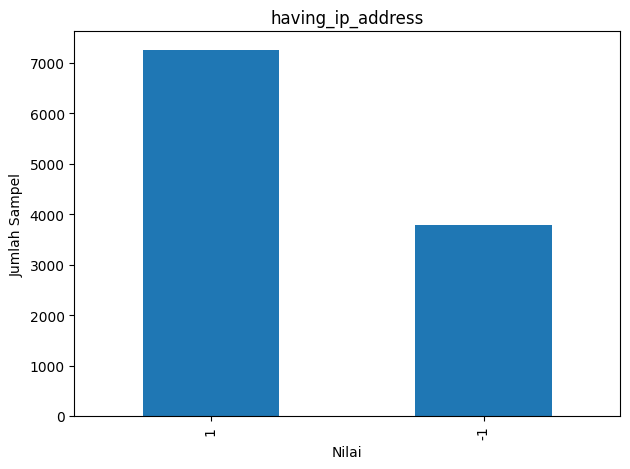


Kolom: shortining_service
                    jumlah sampel  persentase
shortining_service                           
 1                           9611        86.9
-1                           1444        13.1


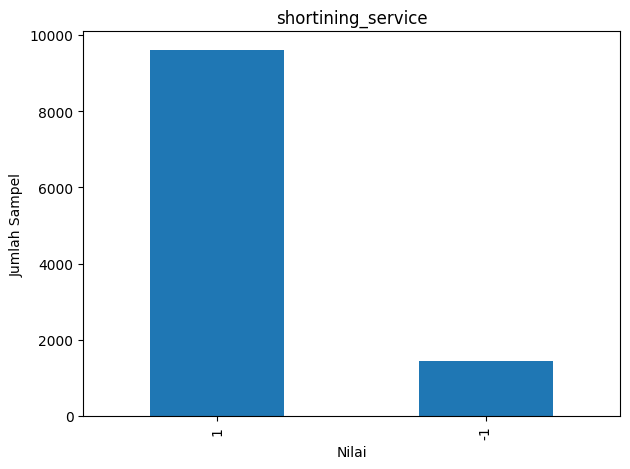


Kolom: having_at_symbol
                  jumlah sampel  persentase
having_at_symbol                           
 1                         9400        85.0
-1                         1655        15.0


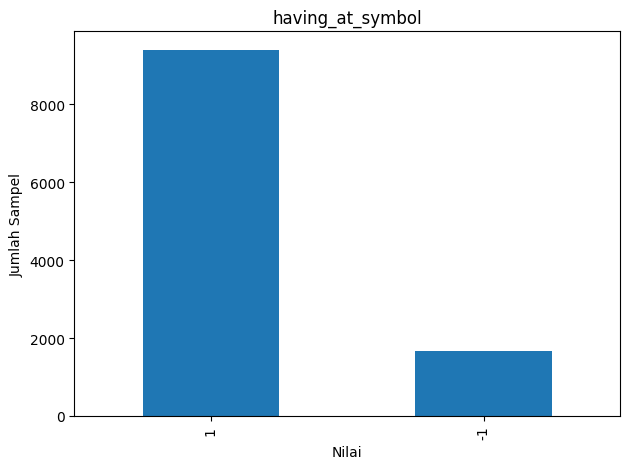


Kolom: double_slash_redirecting
                          jumlah sampel  persentase
double_slash_redirecting                           
 1                                 9626        87.1
-1                                 1429        12.9


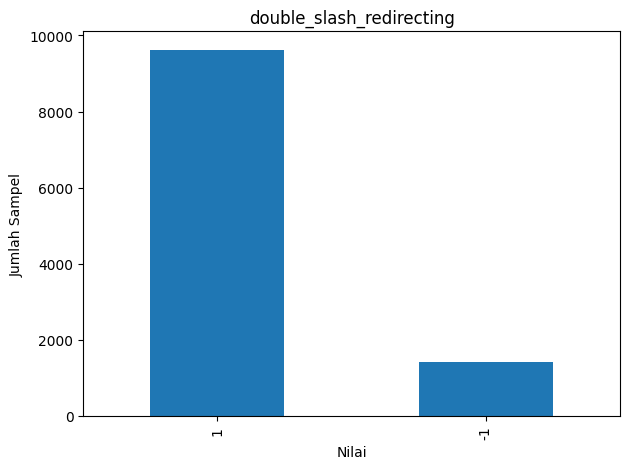


Kolom: prefix_suffix
               jumlah sampel  persentase
prefix_suffix                           
-1                      9590        86.7
 1                      1465        13.3


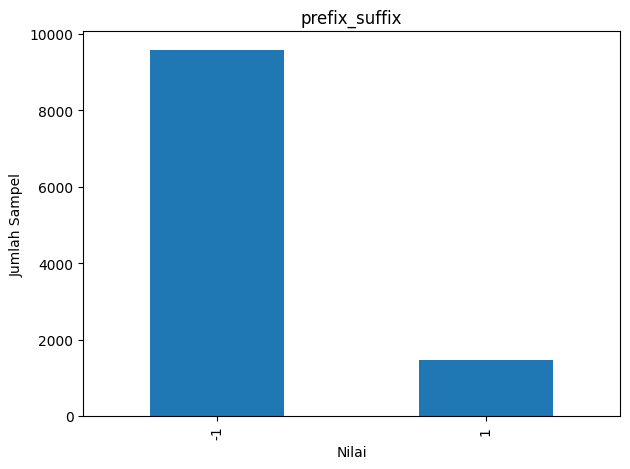


Kolom: domain_registration_length
                            jumlah sampel  persentase
domain_registration_length                           
-1                                   7389        66.8
 1                                   3666        33.2


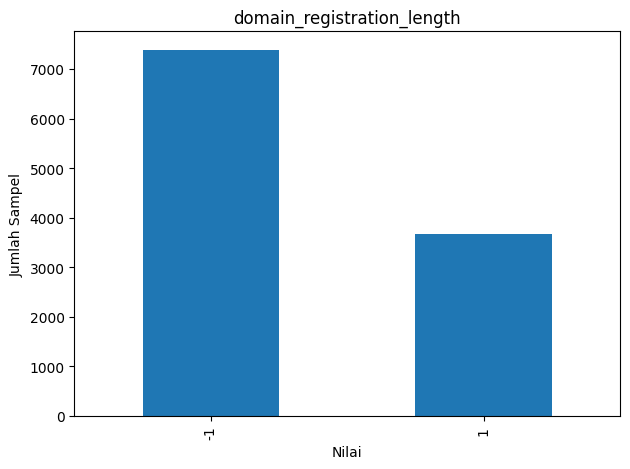


Kolom: favicon
         jumlah sampel  persentase
favicon                           
 1                9002        81.4
-1                2053        18.6


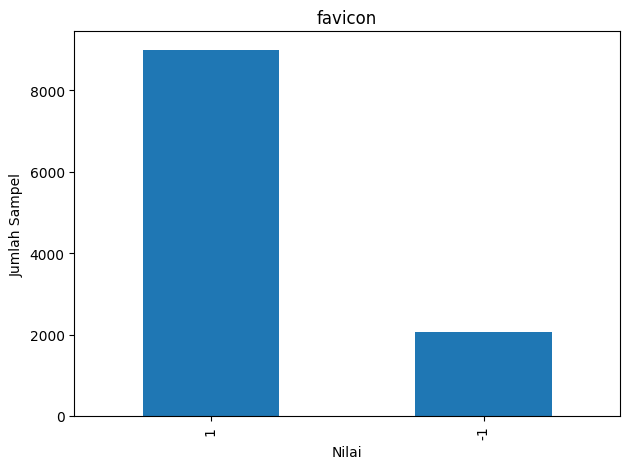


Kolom: port
      jumlah sampel  persentase
port                           
 1             9553        86.4
-1             1502        13.6


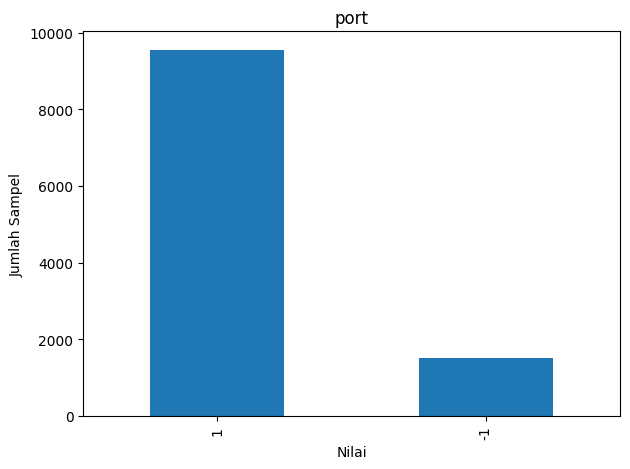


Kolom: https_token
             jumlah sampel  persentase
https_token                           
 1                    9259        83.8
-1                    1796        16.2


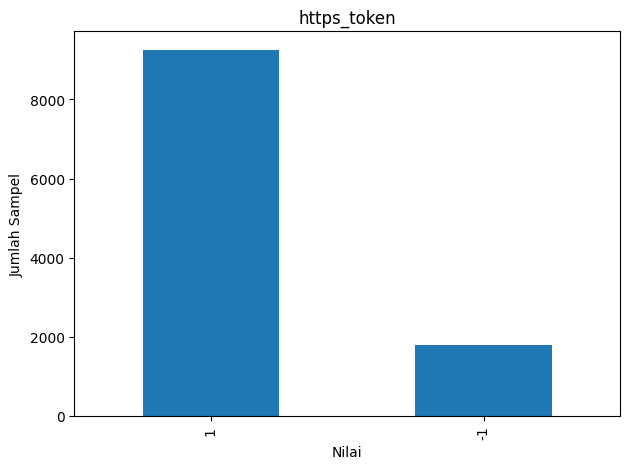


Kolom: request_url
             jumlah sampel  persentase
request_url                           
 1                    6560        59.3
-1                    4495        40.7


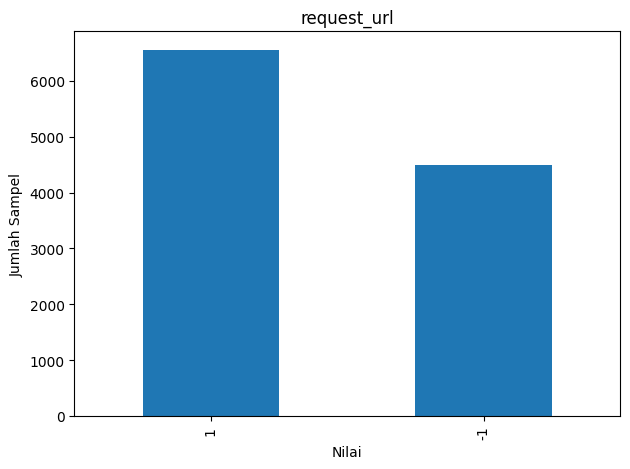


Kolom: submitting_to_email
                     jumlah sampel  persentase
submitting_to_email                           
 1                            9041        81.8
-1                            2014        18.2


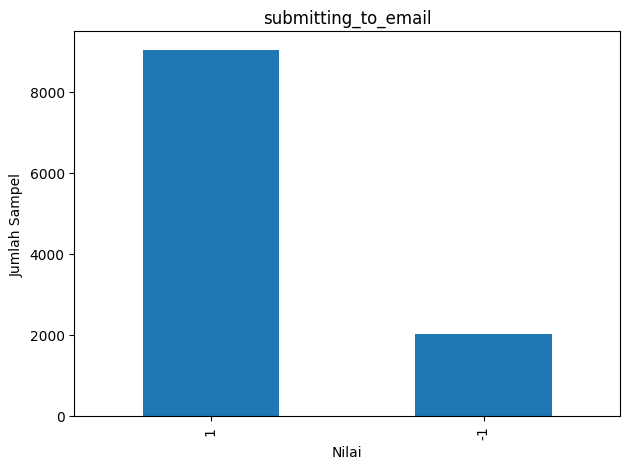


Kolom: abnormal_url
              jumlah sampel  persentase
abnormal_url                           
 1                     9426        85.3
-1                     1629        14.7


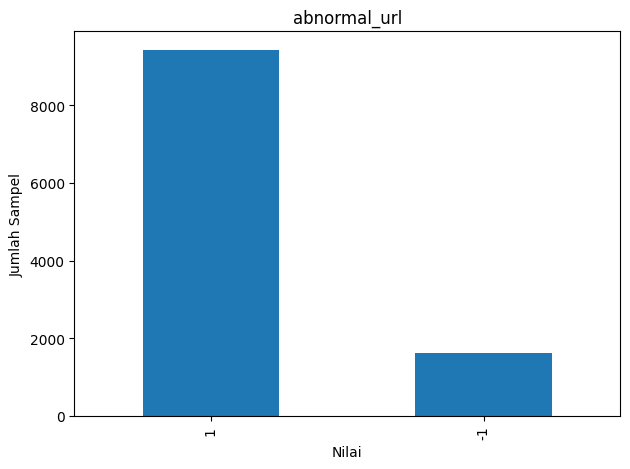


Kolom: redirect
          jumlah sampel  persentase
redirect                           
0                  9776        88.4
1                  1279        11.6


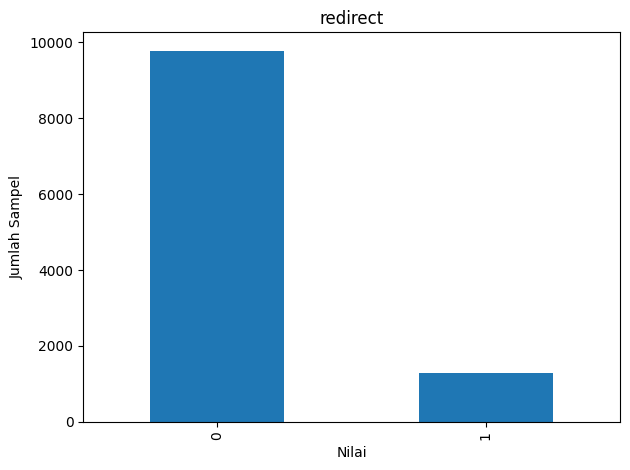


Kolom: on_mouseover
              jumlah sampel  persentase
on_mouseover                           
 1                     9740        88.1
-1                     1315        11.9


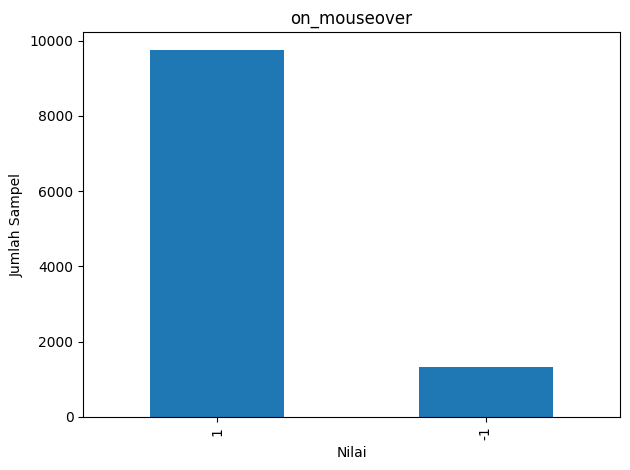


Kolom: rightclick
            jumlah sampel  persentase
rightclick                           
 1                  10579        95.7
-1                    476         4.3


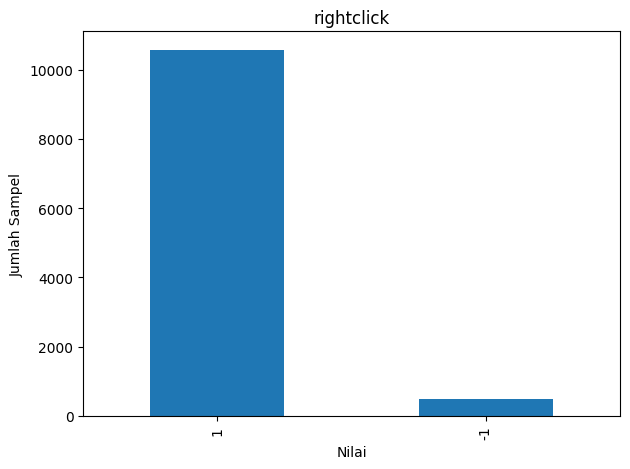


Kolom: popupwindow
             jumlah sampel  persentase
popupwindow                           
 1                    8918        80.7
-1                    2137        19.3


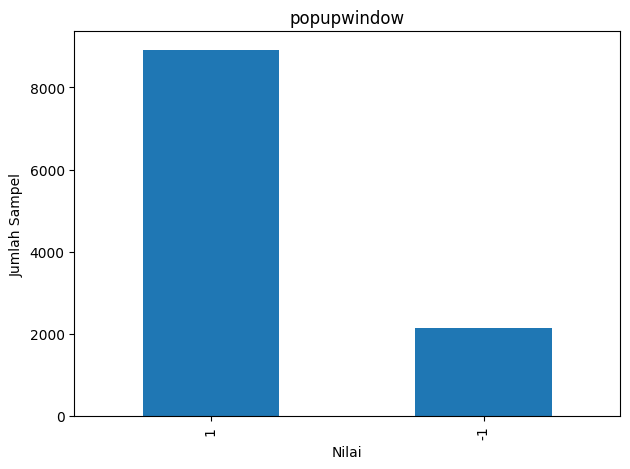


Kolom: iframe
        jumlah sampel  persentase
iframe                           
 1              10043        90.8
-1               1012         9.2


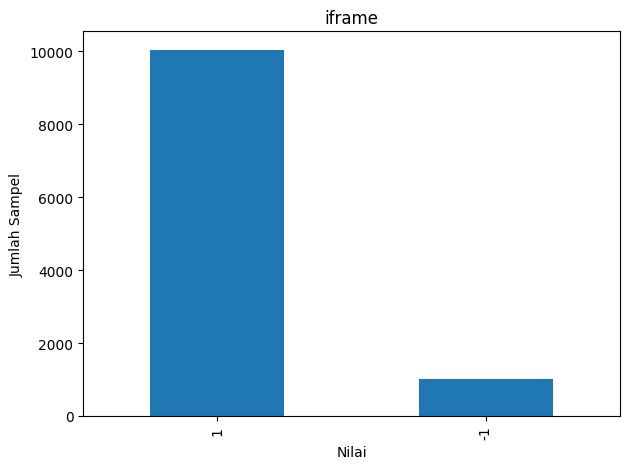


Kolom: age_of_domain
               jumlah sampel  persentase
age_of_domain                           
 1                      5866        53.1
-1                      5189        46.9


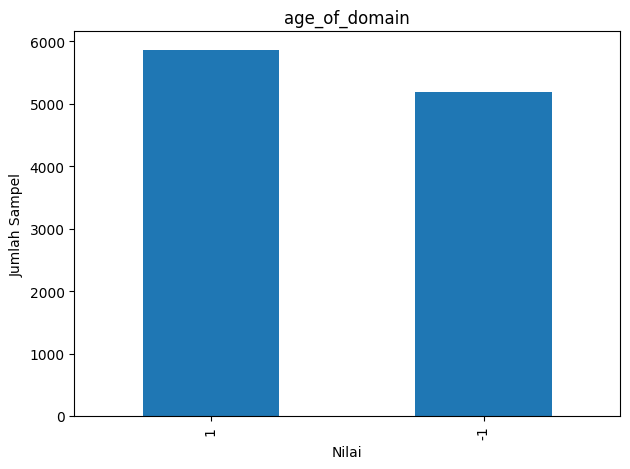


Kolom: dnsrecord
           jumlah sampel  persentase
dnsrecord                           
 1                  7612        68.9
-1                  3443        31.1


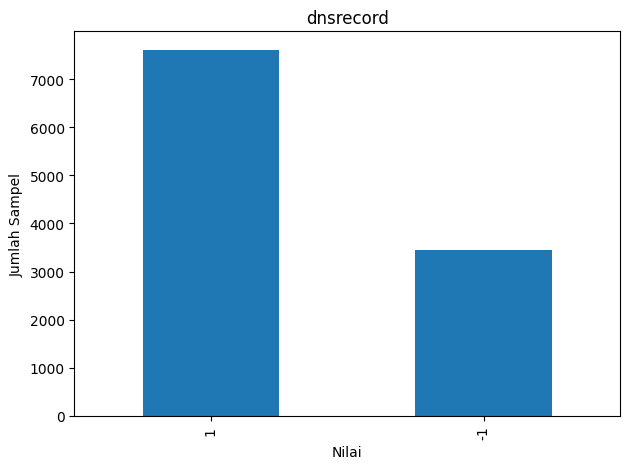


Kolom: page_rank
           jumlah sampel  persentase
page_rank                           
-1                  8201        74.2
 1                  2854        25.8


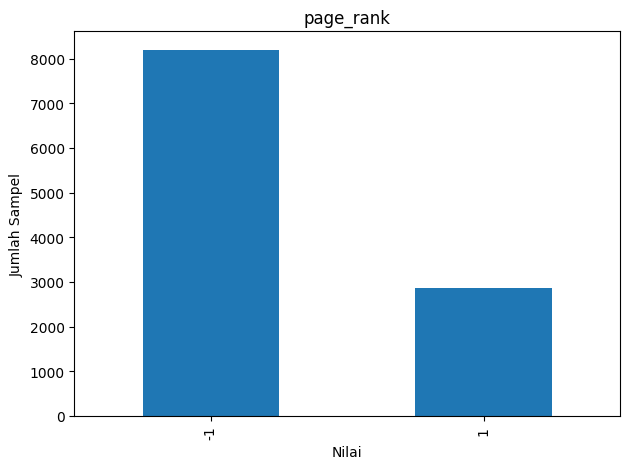


Kolom: google_index
              jumlah sampel  persentase
google_index                           
 1                     9516        86.1
-1                     1539        13.9


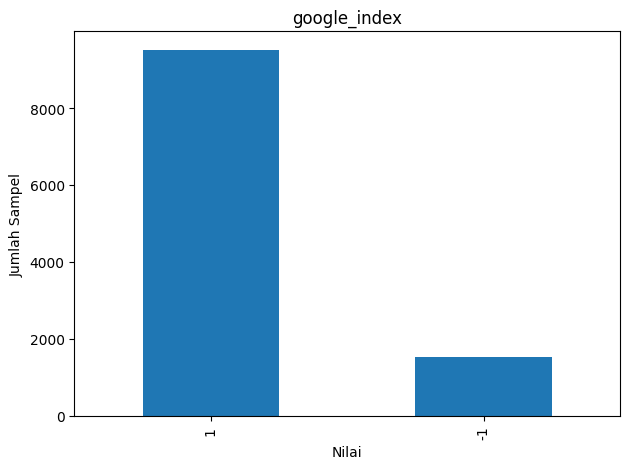


Kolom: statistical_report
                    jumlah sampel  persentase
statistical_report                           
 1                           9505        86.0
-1                           1550        14.0


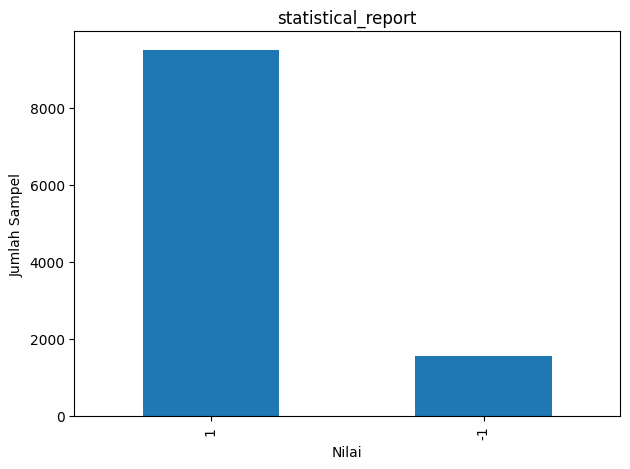

In [13]:


for i in boolean_col:
    count = X[i].value_counts()
    percent = 100 * X[i].value_counts(normalize=True)
    df = pd.DataFrame({'jumlah sampel': count, 'persentase': percent.round(1)})
    print(f"\nKolom: {i}")
    print(df)
    
    # Plot
    count.plot(kind='bar', title=i)
    plt.xlabel('Nilai')
    plt.ylabel('Jumlah Sampel')
    plt.tight_layout()
    plt.show()


Dari hasil visualisasi persebaran value di tiap data boolean, hampir seluruh fitur memiliki kondisi imbalance. Nilai fitur lebih condong ke 1 (True)

## Category Feature


Kolom: url_length
            jumlah sampel  persentase
url_length                           
-1                   8960        81.0
 1                   1960        17.7
 0                    135         1.2


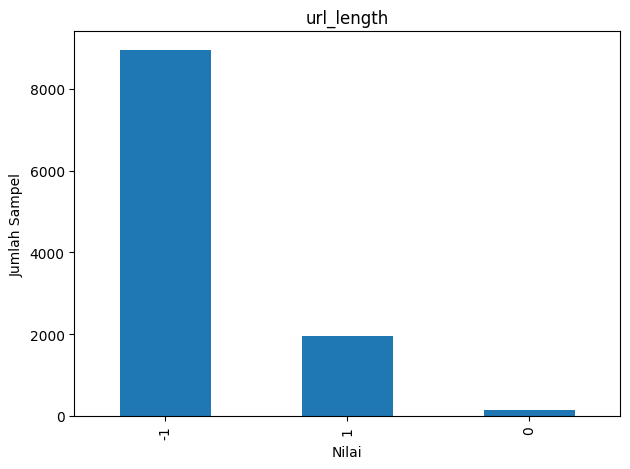


Kolom: having_sub_domain
                   jumlah sampel  persentase
having_sub_domain                           
 1                          4070        36.8
 0                          3622        32.8
-1                          3363        30.4


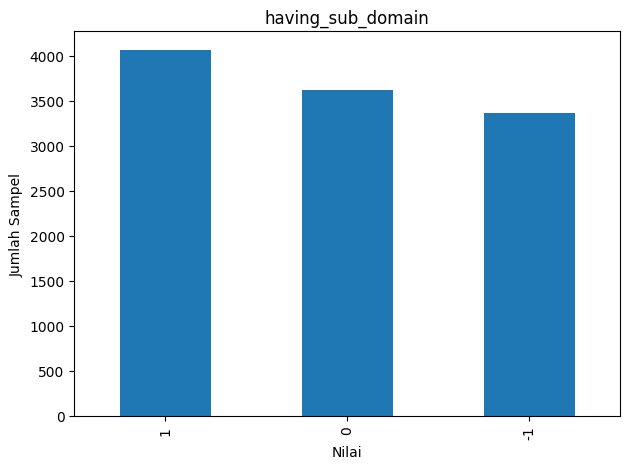


Kolom: sslfinal_state
                jumlah sampel  persentase
sslfinal_state                           
 1                       6331        57.3
-1                       3557        32.2
 0                       1167        10.6


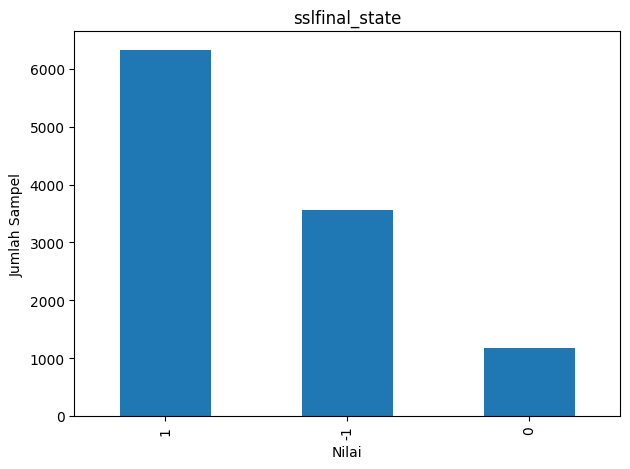


Kolom: url_of_anchor
               jumlah sampel  persentase
url_of_anchor                           
 0                      5337        48.3
-1                      3282        29.7
 1                      2436        22.0


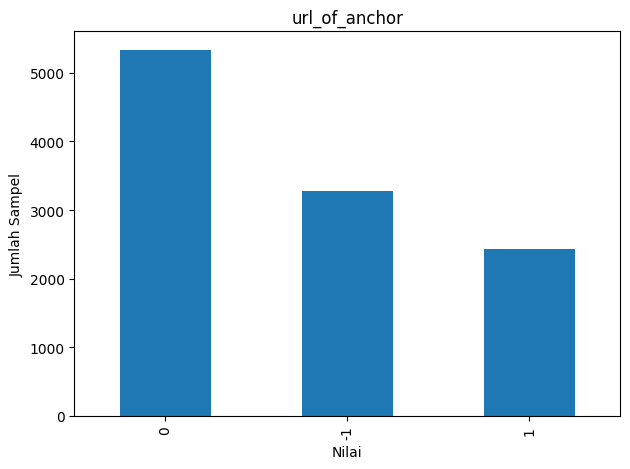


Kolom: links_in_tags
               jumlah sampel  persentase
links_in_tags                           
 0                      4449        40.2
-1                      3956        35.8
 1                      2650        24.0


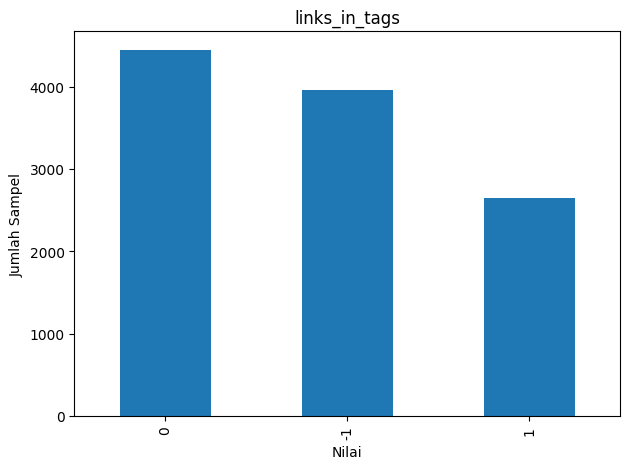


Kolom: sfh
     jumlah sampel  persentase
sfh                           
-1            8440        76.3
 1            1854        16.8
 0             761         6.9


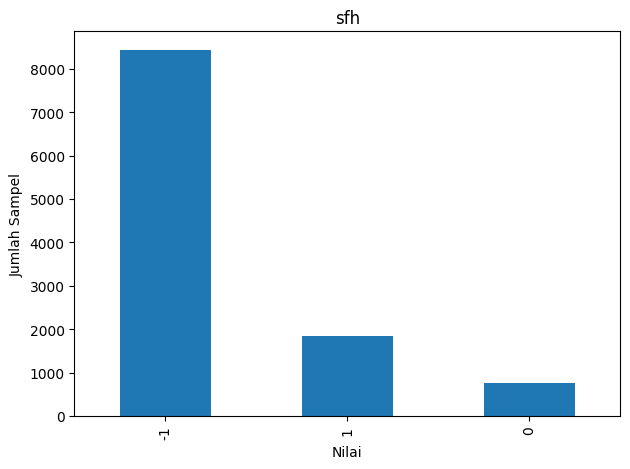


Kolom: web_traffic
             jumlah sampel  persentase
web_traffic                           
 1                    5831        52.7
-1                    2655        24.0
 0                    2569        23.2


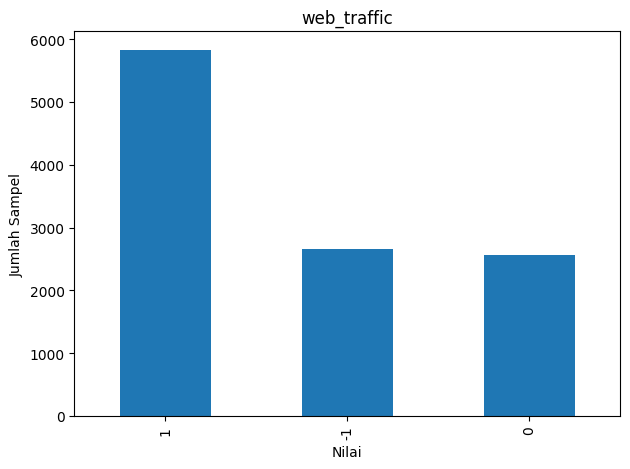


Kolom: links_pointing_to_page
                        jumlah sampel  persentase
links_pointing_to_page                           
 0                               6156        55.7
 1                               4351        39.4
-1                                548         5.0


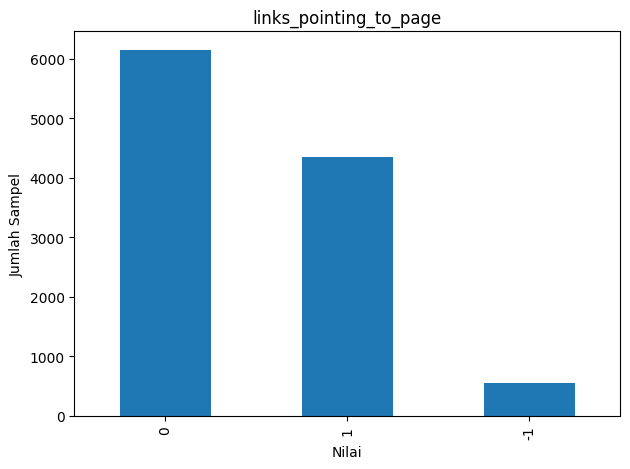

In [14]:


for i in category_col:
    count = X[i].value_counts()
    percent = 100 * X[i].value_counts(normalize=True)
    df = pd.DataFrame({'jumlah sampel': count, 'persentase': percent.round(1)})
    print(f"\nKolom: {i}")
    print(df)
    
    # Plot
    count.plot(kind='bar', title=i)
    plt.xlabel('Nilai')
    plt.ylabel('Jumlah Sampel')
    plt.tight_layout()
    plt.show()


Fitur kategorikal menunjukkan adanya ketidakseimbangan data, namun tingkat ketidakseimbangannya tidak sebesar pada fitur boolean

# Multivariate Analysis

## Multiple Correspondence Analysis

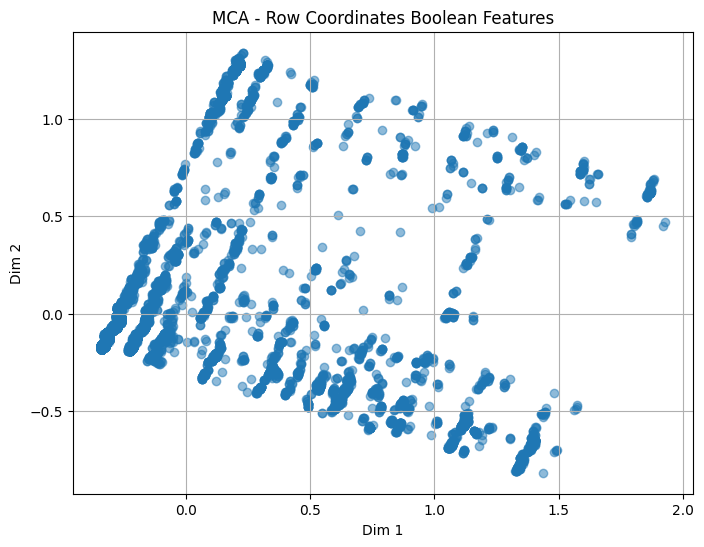

In [15]:
# Fit MCA
mca = prince.MCA(n_components=2, random_state=42)
mca = mca.fit(X[boolean_col])

# Ambil koordinat baris (observasi)
row_coords = mca.transform(X[boolean_col])

# Plot hasil
plt.figure(figsize=(8, 6))
plt.scatter(row_coords[0], row_coords[1], alpha=0.5)
plt.title("MCA - Row Coordinates Boolean Features")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

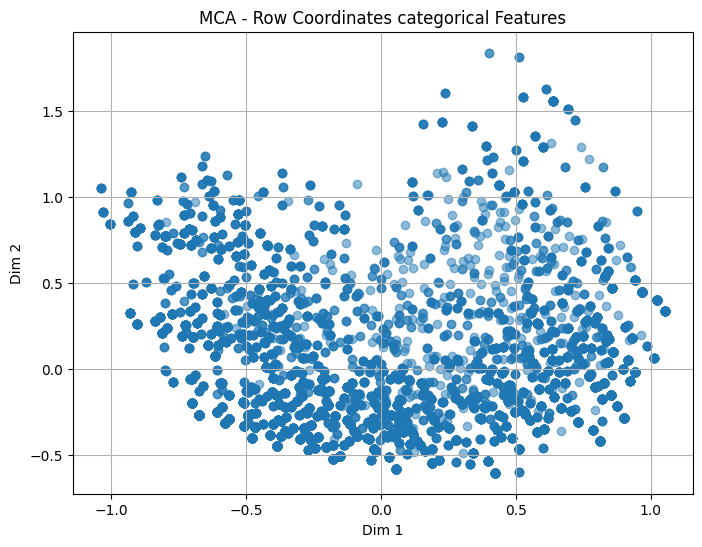

In [16]:
# Fit MCA
mca = prince.MCA(n_components=2, random_state=42)
mca = mca.fit(X[category_col])

# Ambil koordinat baris (observasi)
row_coords = mca.transform(X[category_col])

# Plot hasil
plt.figure(figsize=(8, 6))
plt.scatter(row_coords[0], row_coords[1], alpha=0.5)
plt.title("MCA - Row Coordinates categorical Features")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

Plot Kedua: MCA untuk Fitur Boolean
- Terlihat pola garis-garis sejajar secara vertikal.
- Ini mengindikasikan bahwa data boolean memiliki banyak duplikasi kombinasi atau kombinasi nilai yang terbatas, sehingga hasilnya terlihat berlapis atau tersusun seperti garis.
- Titik-titik juga tampak lebih tersusun dibanding kategori biasa, yang menegaskan bahwa fitur boolean lebih terbatas variasinya atau 
lebih terpengaruh imbalance

Plot Kedua: MCA untuk Fitur Categorical
- Distribusi titik menyebar cukup merata ke kiri dan ke kanan, meskipun tampak agak mengerucut di tengah.
- Menandakan bahwa ada variasi nyata antar sampel berdasarkan kombinasi fitur kategorikal, meski tidak terlalu kuat (karena titik tidak membentuk klaster yang sangat jelas).
- Titik-titik yang dekat satu sama lain artinya baris-baris (sampel) tersebut punya kombinasi nilai kategori yang mirip.

## Korelasi Fitur dengan Target

### Chi-Square Test of Independence

In [ ]:
results = []

for col in X.columns:
    contingency = pd.crosstab(X[col], y['result'])
    chi2, p, dof, expected = chi2_contingency(contingency)

    results.append({
        'Feature': col,
        'Chi-square': chi2,
        'p-value': p,
        'Degrees of Freedom': dof,
        'Significant': 'Yes' if p < 0.05 else 'No'
    })

# Buat DataFrame
chi2_df = pd.DataFrame(results)

# Urutkan berdasarkan p-value
chi2_df = chi2_df.sort_values(by='p-value')

# Tampilkan
chi2_df

,Feature,Chi-square,p-value,Degrees of Freedom,Significant
6,having_sub_domain,1595.294123,0.000000e+00,2,Yes
7,sslfinal_state,6686.246056,0.000000e+00,2,Yes
13,url_of_anchor,5966.367231,0.000000e+00,2,Yes
25,web_traffic,1712.181255,0.000000e+00,2,Yes
5,prefix_suffix,1341.399192,1.139474e-293,1,Yes
12,request_url,708.665429,3.902709e-156,1,Yes
14,links_in_tags,712.564882,1.855675e-155,2,Yes
8,domain_registration_length,562.628588,2.253279e-124,1,Yes
15,sfh,542.417223,1.642845e-118,2,Yes
27,google_index,183.075832,1.032457e-41,1,Yes


Untuk mengecek korelasi, pada datasets ini, digunakan teknik **Chi-Square Test of Independence**, yaitu uji statistik yang digunakan untuk menentukan apakah dua variabel kategorikal memiliki hubungan atau saling bebas (independen) satu sama lain.

Teknik ini digunakan dengan alasan bahwa teknik umum seperti korelasi matrix tidak akan cocok jika dataset hanya memiliki tipe category saja

Pada hasil Chi-Square diatas, fitur yang memiliki nilai p kecil, fitur tersebut memiliki hubungan yang signifikan dengan target. Dalam analisis ini, nilai p < 0.05 maka dianggap memiliki hubungan yang signifikan dengan target

# Data Preparation

## Dimension Reduction

In [ ]:
mca = prince.MCA(n_components=15, random_state=42)
mca = mca.fit(X)


mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.181,14.30%,14.30%
1,0.138,10.91%,25.21%
2,0.093,7.34%,32.54%
3,0.055,4.36%,36.90%
4,0.051,4.03%,40.93%
5,0.047,3.73%,44.66%
6,0.042,3.33%,47.99%
7,0.040,3.18%,51.17%
8,0.039,3.05%,54.22%


karena setengah fitur yang di reduksi MCA sudah cukup mewakili variance, maka fitur akan di reduksi menjadi 15 fitur dengan MCA


In [33]:
X_reduced = mca.transform(X)

# Cek hasilnya
X_reduced

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.413792,0.592722,0.276242,0.290534,-0.370620,0.036731,-0.272486,0.024652,0.132170,0.049344,0.106787,0.256379,0.073947,-0.406109,0.113110
1,-0.122581,0.208008,-0.023403,0.216761,-0.133678,0.257708,-0.032186,-0.268352,-0.163635,-0.210981,-0.151849,0.058636,-0.063517,0.153469,-0.154097
2,0.191027,0.264639,0.120570,0.108887,-0.376319,0.713616,0.473802,0.712143,0.548942,-0.140924,-0.282709,0.542898,0.155323,0.273344,0.859573
3,-0.122463,0.189967,0.272828,-0.007885,-0.144693,0.714824,0.522568,0.774958,0.818444,-0.063019,-0.181785,0.935621,-0.174431,0.375130,0.182180
4,0.248219,0.093442,-0.074400,0.074152,-0.040633,0.582715,0.506819,0.474749,0.318223,-0.214228,-0.014637,0.445559,-0.015478,0.709075,0.210749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1.140831,-0.673152,-0.479670,-0.312360,0.034715,-0.448424,-0.055131,0.064994,-0.240656,0.317483,0.102541,0.145976,-0.035151,-0.103809,-0.030637
11051,1.010727,0.163684,-0.142660,0.711404,0.608659,0.058099,0.289170,0.108394,0.102585,0.159108,-0.003585,0.389481,0.086155,-0.385954,-0.195195
11052,-0.325019,-0.116203,-0.112848,0.000981,-0.003483,0.142939,0.182136,-0.058587,-0.164299,-0.024556,-0.003931,-0.027454,0.019224,-0.158515,0.108815
11053,0.332252,-0.257383,0.306381,-0.216169,0.004726,-0.116096,0.102960,-0.222396,0.077887,-0.015301,-0.009503,0.243049,0.061624,-0.296249,0.106965


## Splitting Data

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y['result'], test_size=0.2, random_state=42)

In [36]:
print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

Total # of sample in whole dataset: 11055
Total # of sample in train dataset: 8844
Total # of sample in test dataset: 2211


# Modelling

In [38]:
models = pd.DataFrame(index=['train_acc', 'test_acc'], 
                      columns=['LogReg', 'RandomForest', 'XGBoost'])

Pemilihan Model untuk Data Hasil MCA

Saya memilih Logistic Regression, Random Forest, dan XGBoost karena alasan berikut:

- Logistic Regression: Model sederhana dan cepat, cocok untuk data numerik dengan fitur yang sudah orthogonal dari MCA, serta mudah diinterpretasi.

- Random Forest: Mampu menangani hubungan non-linear dan interaksi antar fitur tanpa banyak pra-pemrosesan, cocok untuk menangkap pola kompleks dari data MCA.

- XGBoost: Model boosting yang efisien dan akurat, sangat baik untuk dataset berdimensi sedang dengan pola non-linear yang rumit.

Ketiga model ini memberikan kombinasi yang baik antara interpretabilitas, kekuatan, dan kemampuan menangkap kompleksitas data hasil MCA.

## Logistic Regression

In [50]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Evaluasi akurasi
models.loc['train_acc', 'LogReg'] = logreg.score(X_train, y_train)
models.loc['test_acc', 'LogReg'] = logreg.score(X_test, y_test)

print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.93      0.91      0.92       956
           1       0.93      0.95      0.94      1255

    accuracy                           0.93      2211
   macro avg       0.93      0.93      0.93      2211
weighted avg       0.93      0.93      0.93      2211



## Random Forest

In [51]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluasi akurasi
models.loc['train_acc', 'RandomForest'] = rf.score(X_train, y_train)
models.loc['test_acc', 'RandomForest'] = rf.score(X_test, y_test)

print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.97      0.95      0.96       956
           1       0.96      0.98      0.97      1255

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211



## Xgboost

In [52]:
# Convert -1 labels to 0 for XGBoost compatibility
y_train_xgb = y_train.replace(-1, 0)
y_test_xgb = y_test.replace(-1, 0)

xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgboost.fit(X_train, y_train_xgb)

# Evaluasi akurasi
models.loc['train_acc', 'XGBoost'] = xgboost.score(X_train, y_train_xgb)
models.loc['test_acc', 'XGBoost'] = xgboost.score(X_test, y_test_xgb)


print(classification_report(y_test_xgb, xgboost.predict(X_test)))

d:\CODING\PYTHON\MACHINE_LEARNING\Predictive_analysis\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:56:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.96      0.95      0.96       956
           1       0.96      0.97      0.97      1255

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211



# Evaluation

In [53]:
models

,LogReg,RandomForest,XGBoost
train_acc,0.930348,0.990615,0.990615
test_acc,0.933062,0.963817,0.961556
